<a href="https://colab.research.google.com/github/sayalaruano/MidtermProject-MLZoomCamp/blob/main/EDA_beta_lactamase_drug_discovery_project_version3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Drug discovery project about ligands that bind to Beta-Lactamases**

[Sebastián Ayala Ruano](https://sayalaruano.github.io/)

This notebook is part of my midterm project for the [Machine Learning Zoomcamp](https://datatalks.club/courses/2021-winter-ml-zoomcamp.html). The dataset and challenge was proposed by [Data Professor](https://github.com/dataprofessor) as an Open Bioinformatics Research Project. 

This project aims to evaluate activity of molecules that have been experimentally tested to bind or not bind to [Beta-Lactamases](https://www.rcsb.org/structure/4eyl). Some of these proteins allow multi-drug resistant bacteria or superbugs to inactivate a wide range of penicillin-like antibiotics, which is known as antimicrobial resistance (AMR). 

The feature matrix to train machine learning models is obtained by calculating molecular descriptors from the `canonical_smiles` of molecules. These molecular descriptors are also known as molecular fingerprints, and they are property profiles of molecules, represented as vectors with each vector element representing the existence or the frequency of a structural feature. The extraction of molecular fingerprints from SMILES was performed with [PaDEL](http://www.yapcwsoft.com/dd/padeldescriptor/) software, following instructions from [this video](https://youtu.be/rEmDyZHz5U8).

PaDEL has 12 available fingerprints, but we calculated 10 of them because KlekotaRothFingerprintCount and KlekotaRothFingerprinter required a long computing time to be obtained.

For this project, I tested three machine learning models, including Logistic Regression, Random Forest, and XGBoost, for a binary classification task. 

More details about my midterm project are available in its [GitHub repository](https://github.com/sayalaruano/MidtermProject-MLZoomCamp). 

This [video](https://youtu.be/_GtEgiWWyK4) has more information about the Open Bioinformatics Research Project and how to collaborate in it.

**Note:** `mkdir`, `wget`, and `unzip` are Unix based OS commands, so if you are in Windows, maybe these terminal tools won't work. 

## **Installation of libraries**

In [4]:
# Library to calculate molecular descriptors
!pip install padelpy

In [5]:
# Library for Gradient boosting trees moddels
!pip install xgboost

In [6]:
# Library for machine learning pipelines and models
!pip install scikit-learn==1

     |████████████████████████████████| 25.8 MB 156 kB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


In [7]:
# Library for saving and loading Python objects 
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle
ERROR: No matching distribution found for pickle


## **Imports and data obtention**

In [8]:
# Data manipulation and EDA
import zipfile
import pandas as pd
import numpy as np
import glob
import pickle
from scipy.stats import mannwhitneyu

# Plots
import matplotlib.pyplot as plt

# Molecular descriptors calculation 
from padelpy import padeldescriptor

# Machine learning models
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

In [9]:
# Download data
! mkdir Data 
! wget https://github.com/dataprofessor/beta-lactamase/raw/main/beta_lactamase_CHEMBL29.zip --directory ./Data

mkdir: cannot create directory ‘Data’: File exists
--2021-10-30 16:38:04--  https://github.com/dataprofessor/beta-lactamase/raw/main/beta_lactamase_CHEMBL29.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/beta-lactamase/main/beta_lactamase_CHEMBL29.zip [following]
--2021-10-30 16:38:04--  https://raw.githubusercontent.com/dataprofessor/beta-lactamase/main/beta_lactamase_CHEMBL29.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1416390 (1.4M) [application/zip]
Saving to: ‘./Data/beta_lactamase_CHEMBL29.zip.1’

beta_lactamase_CHEM 100%[===================>]   1.35M  2.55MB/s  

In [10]:
# Concatenate all cv files from zip file into a single unified dataframe
zf = zipfile.ZipFile("Data/beta_lactamase_CHEMBL29.zip", "r")
df = pd.concat( (pd.read_csv( zf.open(f) ) for f in zf.namelist() ) )

In [11]:
# Take a look at the dataframe
df

,molecule_chembl_id,canonical_smiles,standard_relation,standard_value,standard_units,standard_type,pchembl_value,target_pref_name,bao_label
0,CHEMBL1730,CO/N=C(\C(=O)N[C@@H]1C(=O)N2C(C(=O)O)=C(COC(C)...,=,10.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
1,CHEMBL996,CO[C@@]1(NC(=O)Cc2cccs2)C(=O)N2C(C(=O)O)=C(COC...,NaN,NaN,NaN,Kcat/Km,NaN,Gil1,assay format
2,CHEMBL617,CC(=O)OCC1=C(C(=O)O)N2C(=O)[C@@H](NC(=O)Cc3ccc...,=,598.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
3,CHEMBL702,CCN1CCN(C(=O)N[C@@H](C(=O)N[C@@H]2C(=O)N3[C@@H...,=,3400.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
4,CHEMBL1449,CC1(C)S[C@@H]2[C@H](NC(=O)[C@H](C(=O)O)c3ccsc3...,=,10000.0,/mM/s,Kcat/Km,NaN,Gil1,assay format
...,...,...,...,...,...,...,...,...,...
13,CHEMBL561555,COC(=O)CC(N)(CC(=O)OC)C(=O)OCc1ccccc1,NaN,NaN,NaN,Inhibition,NaN,Beta-lactamase VIM-4,single protein format
14,CHEMBL561821,NC(CC(=O)OCc1ccccc1)(CC(=O)OCc1ccccc1)C(=O)OCc...,NaN,NaN,NaN,Inhibition,NaN,Beta-lactamase VIM-4,single protein format
15,CHEMBL561896,COC(=O)CC(CC(=O)OC)(NC(=O)Cc1ccccc1)C(=O)OC,NaN,NaN,NaN,Inhibition,NaN,Beta-lactamase VIM-4,single protein format
16,CHEMBL563044,COC(=O)C(CC(=O)OCc1ccccc1)(CC(=O)OCc1ccccc1)NC...,NaN,NaN,NaN,Inhibition,NaN,Beta-lactamase VIM-4,single protein format


## **Exploratory Data Analysis**

In [12]:
# General measurements of the dataset 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71973 entries, 0 to 17
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  71973 non-null  object 
 1   canonical_smiles    71937 non-null  object 
 2   standard_relation   70934 non-null  object 
 3   standard_value      71185 non-null  float64
 4   standard_units      70521 non-null  object 
 5   standard_type       71969 non-null  object 
 6   pchembl_value       64424 non-null  float64
 7   target_pref_name    71973 non-null  object 
 8   bao_label           71973 non-null  object 
dtypes: float64(2), object(7)
memory usage: 5.5+ MB


### **Target variable: pCHEMBL value**

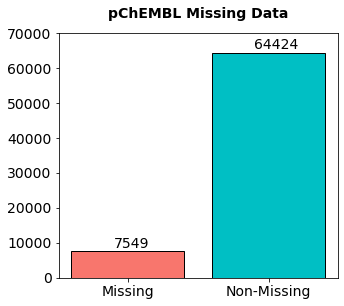

In [13]:
# Bar plot of Missing vs Non-Missing Data of pCHEMBL values

# Data
missing = df.pchembl_value.isnull().sum()
nonmissing = df.pchembl_value.notnull().sum()

x = ['Missing', 'Non-Missing']
y = [missing, nonmissing]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x, y, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('pChEMBL Missing Data', fontsize=14, fontweight='bold', pad=15)

ax.set_ylim(0,70000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label above bar
for index, data in enumerate(y):
    plt.text(x=index-0.1 , y =data+1000 , s=f"{data}" , fontdict=dict(fontsize=14))

fig.set_size_inches(5,4.5)
plt.show()

In [14]:
# Dataset with non-missing pChEMBL values
df2 = df[df.pchembl_value.notnull()]

In [15]:
# General measurements of the dataset 
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64424 entries, 47 to 109
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  64424 non-null  object 
 1   canonical_smiles    64408 non-null  object 
 2   standard_relation   64424 non-null  object 
 3   standard_value      64424 non-null  float64
 4   standard_units      64424 non-null  object 
 5   standard_type       64424 non-null  object 
 6   pchembl_value       64424 non-null  float64
 7   target_pref_name    64424 non-null  object 
 8   bao_label           64424 non-null  object 
dtypes: float64(2), object(7)
memory usage: 4.9+ MB


In [16]:
# Verify duplicated molecules by ChEMBL ID
print('Number of unique ChEMBL ID:', str(len(df2.molecule_chembl_id.unique()) )  )
print('Total number of ChEMBL ID: ', str(len(df2)))

Number of unique ChEMBL ID: 63038
Total number of ChEMBL ID:  64424


I will use a function to replace duplicated molecules by one single row with mean of standard_value and pchembl_value of duplicated rows. The replacement is applied only if standard deviation of pchembl_value is lower than 2.

In [17]:
def combine_molecule_duplicates(dataset):
    '''
    Function to replace duplicated molecules by one single row with mean of standard_value and 
    pchembl_value of duplicated rows. The replacement is applied only if standard deviation of 
    pchembl_value is lower than 2.

        Parameters:
            dataset (DataFrame): A pandas DataFrame with duplicated molecules
        
        Returns: 
            dataset (DataFrame): A pandas DataFrame without duplicated molecules
    '''
    # Calculate standard deviation of all molecules
    std_by_uniqueID = dataset.groupby("molecule_chembl_id").std()

    # Filter standard deviation of duplicated molecules lower than 2
    std_by_uniqueID = std_by_uniqueID[std_by_uniqueID.pchembl_value < 2]

    # Calculate mean of all molecules
    mean_by_uniqueID = dataset.groupby("molecule_chembl_id").mean()
    
    # Filter mean of duplicated molecules that have standard deviation lower than 2
    mean_by_uniqueID = mean_by_uniqueID.filter(items = std_by_uniqueID.index, axis=0)

    # Create a dictionary of rows with mean values of standard_value and pchembl_value
    new_rows = {}

    for i in mean_by_uniqueID.index:
        rows = dataset.loc[dataset.molecule_chembl_id == i].copy()
        row = rows.iloc[0].copy()
        row.standard_value = mean_by_uniqueID.loc[i].standard_value
        row.pchembl_value = mean_by_uniqueID.loc[i].pchembl_value
        new_rows[i] = row
    
    # Convert dictionary to dataframa
    df_new_rows = pd.DataFrame(new_rows).T
    
    # Delete duplicated molecules from the original dataset
    dataset = dataset.drop_duplicates(subset=["molecule_chembl_id"], keep=False)

    # Add new rows to the original dataset
    dataset = pd.concat([dataset, df_new_rows], axis=0).reset_index(drop=True)

    return dataset

In [18]:
# Replace duplicated molecules by mean of their standard_value and pchembl_value
df2_non_duplic = combine_molecule_duplicates(df2)

In [19]:
# Cast pchembl and standard values from object to float 
cast_types = {'standard_value': np.float, 'pchembl_value': np.float}

df2_non_duplic = df2_non_duplic.astype(cast_types)

In [20]:
# General measurements of the dataset 
df2_non_duplic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63030 entries, 0 to 63029
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  63030 non-null  object 
 1   canonical_smiles    63014 non-null  object 
 2   standard_relation   63030 non-null  object 
 3   standard_value      63030 non-null  float64
 4   standard_units      63030 non-null  object 
 5   standard_type       63030 non-null  object 
 6   pchembl_value       63030 non-null  float64
 7   target_pref_name    63030 non-null  object 
 8   bao_label           63030 non-null  object 
dtypes: float64(2), object(7)
memory usage: 4.3+ MB


In [21]:
# Verify that duplicates were deleted 
print('Number of unique ChEMBL ID:', str(len(df2_non_duplic.molecule_chembl_id.unique()) )  )
print('Total number of ChEMBL ID: ', str(len(df2_non_duplic)) )

Number of unique ChEMBL ID: 63030
Total number of ChEMBL ID:  63030


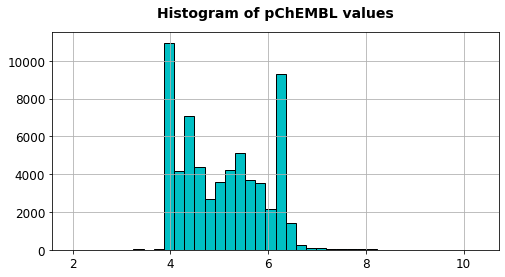

In [22]:
# Distribution of pchembl_values
df2_non_duplic.pchembl_value.hist(bins=40, figsize=(8,4), color='#00BFC4', ec='black')

plt.title('Histogram of pChEMBL values', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

The histogram shows that distribution of this variable has a normal shape, which is because the formula of this coefficient includes log10, so there is no need to apply a transformation in this feature.

In [23]:
# Convert pchembl values to binary ones
# 0 means that molecules are inactive and 1 that they are active 
df2_non_duplic["pchembl_bin"] = (df2_non_duplic["pchembl_value"] >= 5).astype(int)

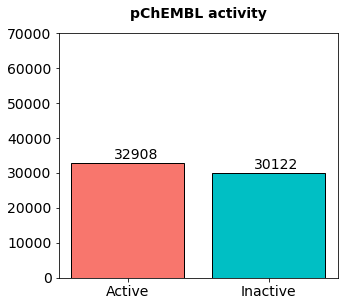

In [24]:
# Bar plot of active and inactive molecules considering pCHEMBL values

# Data
active = len(df2_non_duplic[df2_non_duplic.pchembl_bin == 1])
inactive = len(df2_non_duplic[df2_non_duplic.pchembl_bin == 0])

x = ['Active', 'Inactive']
y = [active, inactive]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x, y, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('pChEMBL activity', fontsize=14, fontweight='bold', pad=15)
#ax.set_xticklabels(x, fontweight='bold')

ax.set_ylim(0,70000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label above bar
for index, data in enumerate(y):
    plt.text(x=index-0.1 , y =data+1000 , s=f"{data}" , fontdict=dict(fontsize=14))

fig.set_size_inches(5,4.5)
plt.show()

We observed that the dataset is not unbalanced regarding pchemb_bin values

Also, I will use a modified version of the function to calculate Mann-Whitney U Test provided by data professor in [this notebook](https://github.com/dataprofessor/code/blob/master/python/CDD_ML_Part_2_Exploratory_Data_Analysis.ipynb). This test will be used for calculating if there are statistical significance differences between active and inactive categories regarding pchembl value.

In [25]:
# Statistical analysis | Mann-Whitney U Test
def mannwhitney(descriptor, dataset, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/

# seed the random number generator
  np.random.seed(1)

# actives and inactives
  selection = [descriptor, 'pchembl_bin']
  df = dataset[selection]
  active = df[df.pchembl_bin == 1]
  active = active[descriptor]

  inactive = df[df.pchembl_bin == 0]
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])

  return results

In [26]:
mannwhitney('pchembl_value', df2_non_duplic)

,Descriptor,Statistics,p,alpha,Interpretation
0,pchembl_value,991254776.0,0.0,0.05,Different distribution (reject H0)


We observed that distributions of active and inactive compounds in terms of pchembl value are statistically different.

### **Other features**

#### **Canonical smiles**

In [27]:
# Get rid of molecules without canonical simles 
df3 = df2_non_duplic[df2_non_duplic.canonical_smiles.notnull()]

In [28]:
# General measurements of the dataset 
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63014 entries, 0 to 63029
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  63014 non-null  object 
 1   canonical_smiles    63014 non-null  object 
 2   standard_relation   63014 non-null  object 
 3   standard_value      63014 non-null  float64
 4   standard_units      63014 non-null  object 
 5   standard_type       63014 non-null  object 
 6   pchembl_value       63014 non-null  float64
 7   target_pref_name    63014 non-null  object 
 8   bao_label           63014 non-null  object 
 9   pchembl_bin         63014 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 5.3+ MB


#### **Target protein**

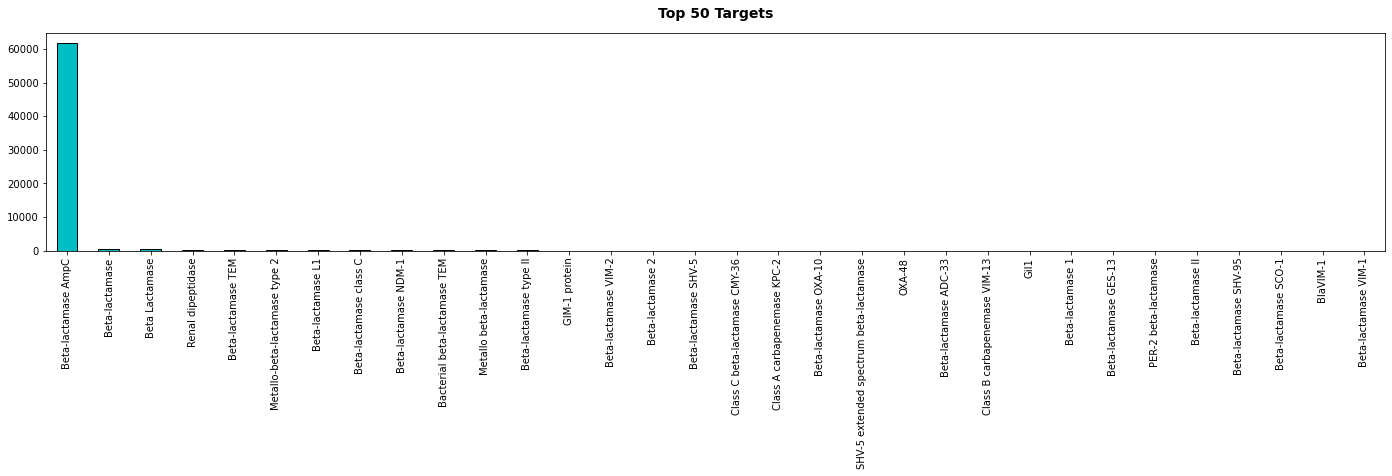

In [29]:
# Distribution of target proteins  
df3.target_pref_name.value_counts()[0:50].plot.bar(figsize=(24,4), color='#00BFC4', ec='black')

plt.title('Top 50 Targets', fontsize=14, fontweight='black', pad=15)
plt.show()

In [30]:
# Filter only molecules tested on Beta-lactamase AmpC
df4 = df3[df3.target_pref_name == "Beta-lactamase AmpC"].reset_index(drop=True)
df4 = df4.sort_values("molecule_chembl_id").reset_index(drop=True)

In [31]:
# Delete CHEMBL412073 moecule because it is not possible to calculate fingerprints of it 
df4 = df4.drop(labels = [61151]).reset_index(drop=True)

It is important to notice that I sorted rows of the datframe by molecule IDs, which will allow us to associate each row with the corrsponding molecular dexriptors calculated with PaDEL. We need to do this because PaDEL outputs are disorderd with respect to the input, so we will sort the originla dataset and the molecular descriptors by molecule IDs. 

In [32]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61736 entries, 0 to 61735
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   molecule_chembl_id  61736 non-null  object 
 1   canonical_smiles    61736 non-null  object 
 2   standard_relation   61736 non-null  object 
 3   standard_value      61736 non-null  float64
 4   standard_units      61736 non-null  object 
 5   standard_type       61736 non-null  object 
 6   pchembl_value       61736 non-null  float64
 7   target_pref_name    61736 non-null  object 
 8   bao_label           61736 non-null  object 
 9   pchembl_bin         61736 non-null  int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 4.7+ MB


We observed that there are not null values in any feature of the dataset

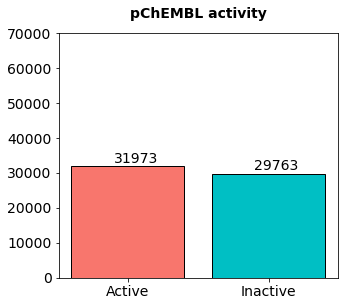

In [33]:
# Bar plot of active and inactive molecules considering pCHEMBL values of Beta-lactamase AmpC target

# Data
active = len(df4[df4.pchembl_bin == 1])
inactive = len(df4[df4.pchembl_bin == 0])

x = ['Active', 'Inactive']
y = [active, inactive]

# Setup plot
fig, ax = plt.subplots()

# Make bar plot
p = ax.bar(x, y, color = ['#F8766D', '#00BFC4'], ec = 'black')

ax.set_title('pChEMBL activity', fontsize=14, fontweight='bold', pad=15)
#ax.set_xticklabels(x, fontweight='bold')

ax.set_ylim(0,70000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Label above bar
for index, data in enumerate(y):
    plt.text(x=index-0.1 , y =data+1000 , s=f"{data}" , fontdict=dict(fontsize=14))

fig.set_size_inches(5,4.5)
plt.show()

#### **Activity type**

We observed that the balance proportion was maintained after filtering molecules that bind to Beta-lactamase AmpC

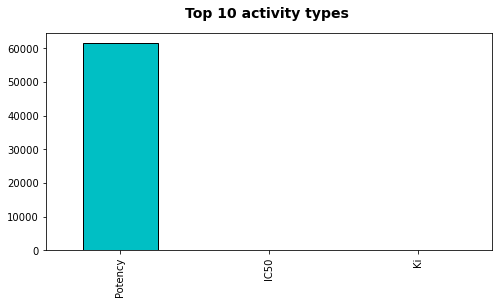

In [34]:
# Top 10 activity types 
df4.standard_type.value_counts()[:10].plot.bar(figsize=(8,4), color='#00BFC4', ec='black')

plt.title('Top 10 activity types ', fontsize=14, fontweight='black', pad=15)
plt.show()

#### **Bioassay ontology**

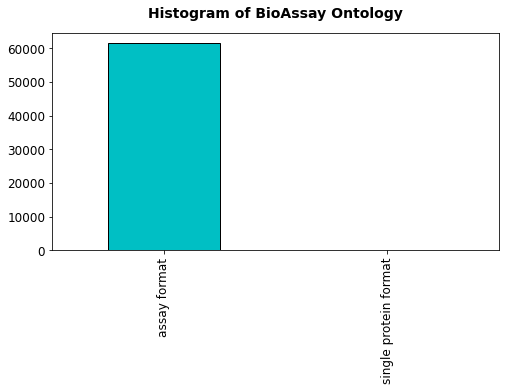

In [35]:
# Histogram of BioAssay Ontology
bao_labels = df4.bao_label.value_counts()
bao_labels.plot.bar(figsize=(8,4), color='#00BFC4', ec='black')

plt.title('Histogram of BioAssay Ontology', fontsize=14, fontweight='black', pad=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## **Feature matrix preparation**

### **Calculation of molecular descriptors from SMILES with PaDEL**
Yo can run this section by yourself, but due to the size of the dataset it can take a while, so I recommend you to use output files provided [here](hhttps://github.com/sayalaruano/MidtermProject-MLZoomCamp/raw/main/Data/MolFingerprints/Results_10molecular_descript_betalact_Padel.zip), and move to the next section to load this data. 

#### **Preparation of files to calculate molecular descriptors**
To make this step yo need to install Padelpy library with pip, as follows: 

```python
pip install padelpy

```

In [ ]:
# Download and unzip fingerprint XML files
! mkdir Data/MolFingerprints
! wget https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip --directory ./Data/MolFingerprints
! unzip Data/MolFingerprints/fingerprints_xml.zip -d Data/MolFingerprints

mkdir: cannot create directory ‘Data/MolFingerprints’: File exists
--2021-10-23 15:12:56--  https://github.com/dataprofessor/padel/raw/main/fingerprints_xml.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip [following]
--2021-10-23 15:12:57--  https://raw.githubusercontent.com/dataprofessor/padel/main/fingerprints_xml.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10871 (11K) [application/zip]
Saving to: ‘./Data/MolFingerprints/fingerprints_xml.zip.1’

fingerprints_xml.zi 100%[===================>]  10.62K  --.-KB/s    in 0.002s  

2021-10-23 

In [ ]:
# List and sort fingerprint XML files
xml_files = glob.glob("Data/MolFingerprints/*.xml")
xml_files.sort()

In [ ]:
# Delete the most computational demanding molecular fingerprints
xml_files.remove("Data/MolFingerprints/KlekotaRothFingerprintCount.xml")
xml_files.remove("Data/MolFingerprints/KlekotaRothFingerprinter.xml")
xml_files

In [ ]:
# Create a list with shorten names of xml files
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [ ]:
# Create a dictionary with shorten names as keys and xml file names as values
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'Data/MolFingerprints/AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'Data/MolFingerprints/AtomPairs2DFingerprinter.xml',
 'EState': 'Data/MolFingerprints/EStateFingerprinter.xml',
 'CDKextended': 'Data/MolFingerprints/ExtendedFingerprinter.xml',
 'CDK': 'Data/MolFingerprints/Fingerprinter.xml',
 'CDKgraphonly': 'Data/MolFingerprints/GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'Data/MolFingerprints/KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'Data/MolFingerprints/KlekotaRothFingerprinter.xml',
 'MACCS': 'Data/MolFingerprints/MACCSFingerprinter.xml',
 'PubChem': 'Data/MolFingerprints/PubchemFingerprinter.xml',
 'SubstructureCount': 'Data/MolFingerprints/SubstructureFingerprintCount.xml',
 'Substructure': 'Data/MolFingerprints/SubstructureFingerprinter.xml'}

In [ ]:
# Prepare data subset as input to PaDELpy and export it as .smi file
df_padelpy = pd.concat( [df4['canonical_smiles'], df4['molecule_chembl_id']], axis=1 )
df_padelpy.to_csv('Data/molecule.smi', sep='\t', index=False, header=False)
df_padelpy

,canonical_smiles,molecule_chembl_id
295,COC1=CC2CC(=O)N(C2)C1C(=O)OCc1ccc([N+](=O)[O-]...,CHEMBL606647
296,CC1(C)S[C@@H]2[C@@H](CO)C(=O)N2[C@H]1C(=O)O,CHEMBL277857
297,CC[C@@H]1C(=O)N2C[C@@H]1CC(OC)=C2C(=O)O,CHEMBL84953
298,C[C@H](O)[C@H]1C(=O)N2[C@@H](C(=O)[O-])C(C)(C)...,CHEMBL177772
299,C[C@H](O)[C@@H]1C(=O)N2[C@@H](C(=O)[O-])C(C)(C...,CHEMBL175189
...,...,...
63006,C[C@]1(Cn2ccnn2)[C@H](C(=O)[O-])N2C(=O)[C@@H](...,CHEMBL6533
63007,CO/N=C/[C@@]1(C)[C@H](C(=O)[O-])N2C(=O)[C@@H](...,CHEMBL6678
63013,O=C(O)c1ccccn1,CHEMBL72628
63017,O=C(O)c1ccc(B(O)O)cc1,CHEMBL82324


#### **Calculate descriptors**
We calculated only 10 descriptors. KlekotaRoth and KlekotaRothCount fingerprints were excluded because they required a long computing time to be obtained. The output data is available [here](hhttps://github.com/sayalaruano/MidtermProject-MLZoomCamp/raw/main/Data/MolFingerprints/Results_10molecular_descript_betalact_Padel.zip).

In [ ]:
for i in fp:
    path = "Data/MolFingerprints/Results/Original"
    fingerprint = i
    fingerprint_output_file_path = ''.join([path,fingerprint]) 
    fingerprint_output_file = ''.join([fingerprint_output_file_path,'.csv']) 
    fingerprint_descriptortypes = fp[fingerprint]

    padeldescriptor(mol_dir='molecule.smi', 
                    d_file=fingerprint_output_file, 
                    descriptortypes= fingerprint_descriptortypes,
                    detectaromaticity=True,
                    standardizenitro=True,
                    standardizetautomers=True,
                    threads=2,
                    removesalt=True,
                    log=True,
                    fingerprints=True)

### **Load molecular descriptors and remove low variance features**

In [36]:
# Create a list with shorten names of xml files
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [ ]:
# Download and unzip calculated molecular descriptor files
! mkdir Data/MolFingerprints/Results
! wget https://github.com/sayalaruano/MidtermProject-MLZoomCamp/raw/main/Data/MolFingerprints/Results_10molecular_descript_betalact_Padel.zip --directory Data/MolFingerprints/Results
! unzip Data/MolFingerprints/Results/Results_10molecular_descript_betalact_Padel.zip -d Data/MolFingerprints/Results

In [38]:
# Load original molecular descriptor files and storage them in a dictionary
descriptors = {}

for i in FP_list:
    path = "Data/MolFingerprints/Results/"
    fingerprint_file_path = ''.join([path,i])
    
    descriptor_name_csv = ''.join([fingerprint_file_path,'.csv'])

    print(descriptor_name_csv)

    descriptors[str(i)] = pd.read_csv(descriptor_name_csv)

    descriptors[str(i)] = descriptors[str(i)].sort_values("Name").reset_index(drop=True)

Data/MolFingerprints/Results/Original/AtomPairs2DCount.csv
Data/MolFingerprints/Results/Original/AtomPairs2D.csv
Data/MolFingerprints/Results/Original/EState.csv
Data/MolFingerprints/Results/Original/CDKextended.csv
Data/MolFingerprints/Results/Original/CDK.csv
Data/MolFingerprints/Results/Original/CDKgraphonly.csv
Data/MolFingerprints/Results/Original/MACCS.csv
Data/MolFingerprints/Results/Original/PubChem.csv
Data/MolFingerprints/Results/Original/SubstructureCount.csv
Data/MolFingerprints/Results/Original/Substructure.csv


In [39]:
# Function to remove low variance features
def remove_low_variance(input_data, threshold=0.1):
    selection = VarianceThreshold(threshold)
    selection.fit(input_data)
    return input_data[input_data.columns[selection.get_support(indices=True)]]

In [41]:
# Create a dictionary of dataframe with low variance descriptors
low_var_descriptors = {}

for i,j in descriptors.items():
  temp = j.drop('Name', axis=1)
  low_var_descriptors[i] = remove_low_variance(temp, threshold=(.8*(1-.8)))

## **Machine learning models and feature enginnering**
I testet three classifiers: 
* Logistic Regression 
* Random Forest 
* Xboost 

I performed feature tuning with skleanr class [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). This class allows to specify a grid with features for tuning, and also the number of folds if we want to use kfold cross validation for this process. So, I obtained the best set of features for each model in this way.

### **Models with low variance descriptors**

In [ ]:
# Dataframe to save performance metrics of the best models
results = pd.DataFrame(columns=['Dataset', 'Model', 'ROC_AUC_cv', 'ROC_AUC_test',
                                'Accuracy_cv', 'Accuracy_test', 'Precision_cv', 
                                'Precison_test', 'Recall_cv', 'Recall_test', 
                                'F1score_cv', 'F1score_test'])

In [43]:
# Series for the target variable 
y = df4.pchembl_bin

#### **Logisic regression**

In [ ]:
# A different model for feature matrices of each fingerprint 
for i, j in low_var_descriptors.items():

    # Data splitting 
    X_train, X_test, y_train, y_test = train_test_split(j, y, test_size=0.2, 
                                                        random_state=42)

    # Set the grid of parameters of GridSearchCV
    tuned_parameters_log_reg = [
        {"penalty": ["l1"], "solver": ["saga"], "C": [0.01, 0.1, 1, 10, 100], 
        "max_iter": [1000], "n_jobs":[-1], "random_state": [10]}
    ]

    print(f'# Tuning hyper-parameters Log reg {i}')
    print()

    # Scoring metrics to be calculated 
    scoring = {"AUC": "roc_auc", "Accuracy": "accuracy", 
               "Precision": "precision", "Recall": "recall", 
               "F1score": "f1"}
    
    # Create GridSearchCV object with its parameters 
    logreg = GridSearchCV(LogisticRegression(), tuned_parameters_log_reg, 
                          scoring=scoring, cv=3, refit="AUC", 
                          return_train_score=True)
    # Train models 
    logreg.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(logreg.best_params_)
    print(logreg.best_score_)

    # Obtain performance metrics of the best model  
    roc_auc_cv = max(logreg.cv_results_["mean_test_AUC"])

    acc_cv = max(logreg.cv_results_["mean_test_Accuracy"])

    prec_cv = max(logreg.cv_results_["mean_test_Precision"])

    recall_cv = max(logreg.cv_results_["mean_test_Recall"])

    f1score_cv = max(logreg.cv_results_["mean_test_F1score"])

    # Add information to the results dataframe
    results = results.append({'Dataset': i, 'Model': 'LogReg', 'ROC_AUC_cv': roc_auc_cv,
                               'Accuracy_cv': acc_cv, 'Precision_cv':prec_cv, 
                               'Recall_cv': recall_cv, 'F1score_cv': f1score_cv}, 
                                ignore_index=True)

# Tuning hyper-parameters Log reg AtomPairs2DCount



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,


Best parameters set found on development set:

{'C': 0.1, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.523258633192433
# Tuning hyper-parameters Log reg AtomPairs2D

Best parameters set found on development set:

{'C': 0.1, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.5110618854139596
# Tuning hyper-parameters Log reg EState

Best parameters set found on development set:

{'C': 0.01, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.5092045620435991
# Tuning hyper-parameters Log reg CDKextended

Best parameters set found on development set:

{'C': 0.1, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.5314079032560591
# Tuning hyper-parameters Log reg CDK

Best parameters set found on development set:

{'C': 100, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.527829758236323
# Tuni

#### **Random Forest**

In [ ]:
# A different model for feature matrices of each fingerprint 
for i, j in low_var_descriptors.items():

    # Data splitting 
    X_train, X_test, y_train, y_test = train_test_split(j, y, test_size=0.2, random_state=42)

    # Set the grid of parameters of GridSearchCV
    tuned_parameters_rf = [
        {"max_depth": [10, 20, 30, 50], "n_estimators": [10, 30, 50, 100, 200], 
          "n_jobs":[-1], "random_state": [10]}
    ]

    print(f'# Tuning hyper-parameters Random Forest {i}')
    print()

    # Scoring metrics to be calculated
    scoring = {"AUC": "roc_auc", "Accuracy": "accuracy", 
               "Precision": "precision", "Recall": "recall", 
               "F1score": "f1"}

    # Create GridSearchCV object with its parameters 
    rf = GridSearchCV(RandomForestClassifier(), tuned_parameters_rf, scoring=scoring, 
                      cv=3, refit="AUC", return_train_score=True)
    
    # Train models 
    rf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(rf.best_params_)
    print(rf.best_score_)

    # Obtain performance metrics of the best model  
    roc_auc_cv = max(rf.cv_results_["mean_test_AUC"])

    acc_cv = max(rf.cv_results_["mean_test_Accuracy"])

    prec_cv = max(rf.cv_results_["mean_test_Precision"])

    recall_cv = max(rf.cv_results_["mean_test_Recall"])

    f1score_cv = max(rf.cv_results_["mean_test_F1score"])

    # Add information to the results dataframe
    results = results.append({'Dataset': i, 'Model': 'RandomForest', 'ROC_AUC_cv': roc_auc_cv,
                               'Accuracy_cv': acc_cv, 'Precision_cv':prec_cv, 
                               'Recall_cv': recall_cv, 'F1score_cv': f1score_cv}, 
                                ignore_index=True)

# Tuning hyper-parameters Random Forest AtomPairs2DCount

Best parameters set found on development set:

{'max_depth': 30, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 10}
0.5455169306006767
# Tuning hyper-parameters Random Forest AtomPairs2D

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 10}
0.5220885627346368
# Tuning hyper-parameters Random Forest EState

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 30, 'n_jobs': -1, 'random_state': 10}
0.5082306147646326
# Tuning hyper-parameters Random Forest CDKextended

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 10}
0.5537381317461437
# Tuning hyper-parameters Random Forest CDK

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 10}
0.5535271654416699
# Tuning hyper-parameters Random Forest CDKgrapho

#### **XGboost**

In [ ]:
# A different model for feature matrices of each fingerprint 
for i, j in low_var_descriptors.items():

    # Data splitting 
    X_train, X_test, y_train, y_test = train_test_split(j, y, test_size=0.2, random_state=42)

    # Set the grid of parameters of GridSearchCV
    tuned_parameters_xvg = [
        {'eta': [0.1, 0.3, 0.5], 
        'max_depth': [5, 10, 20],
        'min_child_weight': [1, 3, 5],
        'objective': ['binary:logistic'],
         'seed': [10],
         'verbosity': [1]}
    ]

    print(f'# Tuning hyper-parameters XGBoost {i}')
    print()

    # Scoring metrics to be calculated 
    scoring = {"AUC": "roc_auc", "Accuracy": "accuracy", 
               "Precision": "precision", "Recall": "recall", 
               "F1score": "f1"}
    
    # Create GridSearchCV object with its parameters 
    xvg = GridSearchCV(xgb.XGBClassifier(), tuned_parameters_xvg, scoring=scoring, 
                      cv=3, refit="AUC", return_train_score=True, n_jobs=-1)
    
    # Train models 
    xvg.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(xvg.best_params_)
    print(xvg.best_score_)
    
    # Obtain performance metrics of the best model 
    roc_auc_cv = max(xvg.cv_results_["mean_test_AUC"])

    acc_cv = max(xvg.cv_results_["mean_test_Accuracy"])

    prec_cv = max(xvg.cv_results_["mean_test_Precision"])

    recall_cv = max(xvg.cv_results_["mean_test_Recall"])

    f1score_cv = max(xvg.cv_results_["mean_test_F1score"])

    # Add information to the results dataframe
    results = results.append({'Dataset': i, 'Model': 'XGBoost', 'ROC_AUC_cv': roc_auc_cv,
                               'Accuracy_cv': acc_cv, 'Precision_cv':prec_cv, 
                               'Recall_cv': recall_cv, 'F1score_cv': f1score_cv }, 
                                ignore_index=True)

# Export results 
results.to_csv("results_ligreg_rf_svc_xgboost.csv")

# Tuning hyper-parameters XGBoost AtomPairs2DCount



C:\Users\dsben\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:35:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 20, 'min_child_weight': 5, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5405849946933042
# Tuning hyper-parameters XGBoost AtomPairs2D



C:\Users\dsben\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:38:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5288562723082479
# Tuning hyper-parameters XGBoost EState



C:\Users\dsben\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:38:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5094361567716598
# Tuning hyper-parameters XGBoost CDKextended



C:\Users\dsben\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:51:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.549788978548707
# Tuning hyper-parameters XGBoost CDK



C:\Users\dsben\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:04:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5485354547475386
# Tuning hyper-parameters XGBoost CDKgraphonly



C:\Users\dsben\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:11:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 10, 'min_child_weight': 5, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5451890393136374
# Tuning hyper-parameters XGBoost MACCS



C:\Users\dsben\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:14:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5419512637775872
# Tuning hyper-parameters XGBoost PubChem



C:\Users\dsben\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:18:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5435363493753781
# Tuning hyper-parameters XGBoost SubstructureCount



C:\Users\dsben\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:20:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 20, 'min_child_weight': 1, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5322919436369383
# Tuning hyper-parameters XGBoost Substructure



C:\Users\dsben\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:20:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best parameters set found on development set:

{'eta': 0.5, 'max_depth': 5, 'min_child_weight': 3, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5120652348640823


#### **Models' evaluation**

In [52]:
# Load results 
results = pd.read_csv("results_ligreg_rf_svc_xgboost.csv")
results.round(3).sort_values("ROC_AUC_cv", ascending=False)

,Unnamed: 0,Dataset,Model,ROC_AUC_cv,Accuracy_cv,Precision_cv,Recall_cv,F1score_cv
14,14,CDK,RandomForest,0.554,0.539,0.546,0.712,0.616
13,13,CDKextended,RandomForest,0.554,0.538,0.548,0.710,0.615
23,23,CDKextended,XGBoost,0.550,0.536,0.548,0.637,0.587
15,15,CDKgraphonly,RandomForest,0.549,0.535,0.543,0.715,0.615
24,24,CDK,XGBoost,0.549,0.533,0.547,0.631,0.584
16,16,MACCS,RandomForest,0.548,0.535,0.543,0.728,0.619
10,10,AtomPairs2DCount,RandomForest,0.546,0.534,0.544,0.885,0.659
25,25,CDKgraphonly,XGBoost,0.545,0.532,0.546,0.646,0.589
27,27,PubChem,XGBoost,0.544,0.530,0.546,0.650,0.589
17,17,PubChem,RandomForest,0.544,0.533,0.547,0.726,0.617


### **Models with low variance descriptors that were the most correlated with target variable**
I tested if using only the 20 most correlated features with target variable as feature matrix improve our models. 

In [ ]:
# Dictionary to save the 20 most correlated features with target variable for each 
# fingerprint
corr_feat_target = {}
for i,j in low_var_descriptors.items():

    corr_feat = pd.DataFrame(j.corrwith(df4.pchembl_bin), 
                             columns = ["Corr"]).sort_values(by=['Corr'],
                              ascending=False)

    temp = j[corr_feat.head(20).index]
    
    corr_feat_target[i] = temp

In [55]:
# Dataframe to save performance metrics of the best models
results_corr_feat = pd.DataFrame(columns=['Dataset', 'Model', 'ROC_AUC_cv', 
                                'Accuracy_cv', 'Precision_cv', 'Recall_cv', 
                                'Recall_test', 'F1score_cv'])

#### **Logistic Regression**

In [60]:
# A different model for feature matrices of each fingerprint 
for i, j in corr_feat_target.items():

    # Data splitting 
    X_train, X_test, y_train, y_test = train_test_split(j, y, test_size=0.2, 
                                                        random_state=42)

    # Set the grid of parameters of GridSearchCV
    tuned_parameters_log_reg = [
        {"penalty": ["l1"], "solver": ["saga"], "C": [0.01, 0.1, 1, 10, 100], 
        "max_iter": [1000], "n_jobs":[-1], "random_state": [10]}
    ]

    print(f'# Tuning hyper-parameters Log reg {i}')
    print()

    # Scoring metrics to be calculated 
    scoring = {"AUC": "roc_auc", "Accuracy": "accuracy", 
               "Precision": "precision", "Recall": "recall", 
               "F1score": "f1"}
    
    # Create GridSearchCV object with its parameters 
    logreg = GridSearchCV(LogisticRegression(), tuned_parameters_log_reg, 
                          scoring=scoring, cv=3, refit="AUC", 
                          return_train_score=True)
    # Train models 
    logreg.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(logreg.best_params_)
    print(logreg.best_score_)

    # Obtain performance metrics of the best model  
    roc_auc_cv = max(logreg.cv_results_["mean_test_AUC"])

    acc_cv = max(logreg.cv_results_["mean_test_Accuracy"])

    prec_cv = max(logreg.cv_results_["mean_test_Precision"])

    recall_cv = max(logreg.cv_results_["mean_test_Recall"])

    f1score_cv = max(logreg.cv_results_["mean_test_F1score"])

    # Add information to the results dataframe
    results_corr_feat = results_corr_feat.append({'Dataset': i, 'Model': 'LogReg', 'ROC_AUC_cv': roc_auc_cv,
                               'Accuracy_cv': acc_cv, 'Precision_cv':prec_cv, 
                               'Recall_cv': recall_cv, 'F1score_cv': f1score_cv}, 
                                ignore_index=True)

# Tuning hyper-parameters Log reg AtomPairs2DCount

Best parameters set found on development set:

{'C': 100, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.5177843824826658
# Tuning hyper-parameters Log reg AtomPairs2D

Best parameters set found on development set:

{'C': 100, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.5063907491152313
# Tuning hyper-parameters Log reg EState

Best parameters set found on development set:

{'C': 0.01, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.5092045620435991
# Tuning hyper-parameters Log reg CDKextended

Best parameters set found on development set:

{'C': 0.1, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_state': 10, 'solver': 'saga'}
0.5254886226873375
# Tuning hyper-parameters Log reg CDK

Best parameters set found on development set:

{'C': 0.1, 'max_iter': 1000, 'n_jobs': -1, 'penalty': 'l1', 'random_s

#### **Random Forest**

In [61]:
# A different model for feature matrices of each fingerprint 
for i, j in corr_feat_target.items():

    # Data splitting 
    X_train, X_test, y_train, y_test = train_test_split(j, y, test_size=0.2, random_state=42)

    # Set the grid of parameters of GridSearchCV
    tuned_parameters_rf = [
        {"max_depth": [10, 20, 30, 50], "n_estimators": [10, 30, 50, 100, 200], 
          "n_jobs":[-1], "random_state": [10]}
    ]

    print(f'# Tuning hyper-parameters Random Forest {i}')
    print()

    # Scoring metrics to be calculated
    scoring = {"AUC": "roc_auc", "Accuracy": "accuracy", 
               "Precision": "precision", "Recall": "recall", 
               "F1score": "f1"}

    # Create GridSearchCV object with its parameters 
    rf = GridSearchCV(RandomForestClassifier(), tuned_parameters_rf, scoring=scoring, 
                      cv=3, refit="AUC", return_train_score=True)
    
    # Train models 
    rf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(rf.best_params_)
    print(rf.best_score_)

    # Obtain performance metrics of the best model  
    roc_auc_cv = max(rf.cv_results_["mean_test_AUC"])

    acc_cv = max(rf.cv_results_["mean_test_Accuracy"])

    prec_cv = max(rf.cv_results_["mean_test_Precision"])

    recall_cv = max(rf.cv_results_["mean_test_Recall"])

    f1score_cv = max(rf.cv_results_["mean_test_F1score"])

    # Add information to the results dataframe
    results_corr_feat = results_corr_feat.append({'Dataset': i, 'Model': 'RandomForest', 
                                                  'ROC_AUC_cv': roc_auc_cv, 
                                                  'Accuracy_cv': acc_cv, 
                                                  'Precision_cv':prec_cv, 
                                                  'Recall_cv': recall_cv, 
                                                  'F1score_cv': f1score_cv}, 
                                                 ignore_index=True)

# Tuning hyper-parameters Random Forest AtomPairs2DCount

Best parameters set found on development set:

{'max_depth': 30, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 10}
0.5343750201105327
# Tuning hyper-parameters Random Forest AtomPairs2D

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 10}
0.5179000242357054
# Tuning hyper-parameters Random Forest EState

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 30, 'n_jobs': -1, 'random_state': 10}
0.5082622176310951
# Tuning hyper-parameters Random Forest CDKextended

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 10}
0.5359130641592093
# Tuning hyper-parameters Random Forest CDK

Best parameters set found on development set:

{'max_depth': 10, 'n_estimators': 200, 'n_jobs': -1, 'random_state': 10}
0.5342433118094861
# Tuning hyper-parameters Random Forest CDKgrapho

#### **XGBoost**

In [62]:
# A different model for feature matrices of each fingerprint 
for i, j in corr_feat_target.items():

    # Data splitting 
    X_train, X_test, y_train, y_test = train_test_split(j, y, test_size=0.2, random_state=42)

    # Set the grid of parameters of GridSearchCV
    tuned_parameters_xvg = [
        {'eta': [0.1, 0.3, 0.5], 
        'max_depth': [5, 10, 20],
        'min_child_weight': [1, 3, 5],
        'objective': ['binary:logistic'],
         'seed': [10],
         'verbosity': [1]}
    ]

    print(f'# Tuning hyper-parameters XGBoost {i}')
    print()

    # Scoring metrics to be calculated 
    scoring = {"AUC": "roc_auc", "Accuracy": "accuracy", 
               "Precision": "precision", "Recall": "recall", 
               "F1score": "f1"}
    
    # Create GridSearchCV object with its parameters 
    xvg = GridSearchCV(xgb.XGBClassifier(), tuned_parameters_xvg, scoring=scoring, 
                      cv=3, refit="AUC", return_train_score=True, n_jobs=-1)
    
    # Train models 
    xvg.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(xvg.best_params_)
    print(xvg.best_score_)
    
    # Obtain performance metrics of the best model 
    roc_auc_cv = max(xvg.cv_results_["mean_test_AUC"])

    acc_cv = max(xvg.cv_results_["mean_test_Accuracy"])

    prec_cv = max(xvg.cv_results_["mean_test_Precision"])

    recall_cv = max(xvg.cv_results_["mean_test_Recall"])

    f1score_cv = max(xvg.cv_results_["mean_test_F1score"])

    # Add information to the results dataframe
    results_corr_feat = results_corr_feat.append({'Dataset': i, 'Model': 'XGBoost', 
                                                  'ROC_AUC_cv': roc_auc_cv,
                                                  'Accuracy_cv': acc_cv, 
                                                  'Precision_cv':prec_cv, 
                                                  'Recall_cv': recall_cv, 
                                                  'F1score_cv': f1score_cv }, 
                                                 ignore_index=True)

# Export results 
results_corr_feat.to_csv("results_corr_feat_ligreg_rf_svc_xgboost.csv")

# Tuning hyper-parameters XGBoost AtomPairs2DCount

Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 20, 'min_child_weight': 3, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5276445045095572
# Tuning hyper-parameters XGBoost AtomPairs2D

Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 10, 'min_child_weight': 1, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5170802539760802
# Tuning hyper-parameters XGBoost EState

Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5094361567716598
# Tuning hyper-parameters XGBoost CDKextended

Best parameters set found on development set:

{'eta': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'objective': 'binary:logistic', 'seed': 10, 'verbosity': 1}
0.5301387242089376
# Tuning hyper-parameters XGBoost CDK

Best parameters set found on development set:

{'eta': 0.1

#### **Models' evaluation**

In [66]:
# Load results 
results_corr_feat = pd.read_csv("results_corr_feat_ligreg_rf_svc_xgboost.csv")
results_corr_feat.round(3).sort_values("ROC_AUC_cv", ascending=False)

,Unnamed: 0,Dataset,Model,ROC_AUC_cv,Accuracy_cv,Precision_cv,Recall_cv,F1score_cv
13,13,CDKextended,RandomForest,0.536,0.529,0.537,0.669,0.596
14,14,CDK,RandomForest,0.534,0.527,0.535,0.679,0.598
10,10,AtomPairs2DCount,RandomForest,0.534,0.523,0.538,0.837,0.644
18,18,SubstructureCount,RandomForest,0.532,0.524,0.538,0.842,0.647
28,28,SubstructureCount,XGBoost,0.530,0.521,0.536,0.748,0.617
17,17,PubChem,RandomForest,0.530,0.527,0.535,0.701,0.606
23,23,CDKextended,XGBoost,0.530,0.523,0.538,0.639,0.581
20,20,AtomPairs2DCount,XGBoost,0.528,0.522,0.535,0.748,0.618
24,24,CDK,XGBoost,0.527,0.522,0.535,0.659,0.589
15,15,CDKgraphonly,RandomForest,0.527,0.526,0.533,0.687,0.601


The last table shows that using only correlated features with the target variable does not improve performance of our models.

### **Evaluation of the best model on test dataset**

According to the summary tables presented above, the best model was Random Forest with `max_depth` of 10 and `n_estimators` of 200 as parameters, and low variance `CDK` fingerprint as feature matrix. 

Thus, we trained this model again and evaluated it on the test dataset. 


In [44]:
# Data splitting 
X_train, X_test, y_train, y_test = train_test_split(low_var_descriptors["CDK"], y, test_size=0.2, random_state=42)

# Model parameters
max_depth = 10
n_estimators = 200

# Implementation of the best model 
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimators, n_jobs=-1, 
                            random_state=10).fit(X_train, y_train)

In [45]:
# Predicting values with RF model on train and test dataset 
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [46]:
# Dataset to store perfromance metrics
results_finalmodel = pd.DataFrame(columns=['ROC_AUC_train', 'ROC_AUC_test',
                                'Accuracy_train', 'Accuracy_test', 'Precision_train', 
                                'Precison_test', 'Recall_train', 'Recall_test', 
                                'F1score_train', 'F1score_test'])
                                

In [47]:
# Calculate performance metrics
roc_auc_train = roc_auc_score(y_train, y_train_pred)
    
roc_auc_test = roc_auc_score(y_test, y_test_pred)

acc_train = accuracy_score(y_train, y_train_pred)

acc_test = accuracy_score(y_test, y_test_pred)

prec_train = precision_score(y_train, y_train_pred)

prec_test = precision_score(y_test, y_test_pred)

recall_train = recall_score(y_train, y_train_pred)

recall_test = recall_score(y_test, y_test_pred)

f1score_train = f1_score(y_train, y_train_pred)

f1score_test = f1_score(y_test, y_test_pred)

results_finalmodel = results_finalmodel.append({'ROC_AUC_train': roc_auc_train,
                          'ROC_AUC_test': roc_auc_test, 'Accuracy_train': acc_train, 
                          'Accuracy_test': acc_test, 'Precision_train':prec_train, 
                          'Precison_test': prec_test, 'Recall_train': recall_train, 
                          'Recall_test': recall_test, 'F1score_train': f1score_train, 
                          'F1score_test': f1score_test}, ignore_index=True)


In [48]:
# Take a look at the performance metrics result
results_finalmodel.round(3).T

,0
ROC_AUC_train,0.998
ROC_AUC_test,0.532
Accuracy_train,0.998
Accuracy_test,0.533
Precision_train,0.998
Precison_test,0.542
Recall_train,0.998
Recall_test,0.577
F1score_train,0.998
F1score_test,0.559


### **Save the best model into a file**

In [51]:
# Define the output file's name
output_file = f'RandomForest_maxdepth{max_depth}_nestimators{n_estimators}'
output_file

'RandomForest_maxdepth100_nestimators200'

In [ ]:
with open(output_file, "wb") as f_out:
    pickle.dump(rf, f_out)

Considering all performacne metrics it is evident that this model is overfitting because it is performing well on the training dataset, but it is not doing well on test dataset. 

## **Conclusions and further work**

In this notebook, I performed exploratory data analysis, calculation of molecular descriptors to represent molecules, and use these feature matrices as input of three ML classifiers, including Logistic Regression, Random Forest, and XGBoost.

The best model was Random Forest with `max_depth` of 10 and `n_estimators` of 200 as parameters, and low variance `CDK` fingerprint as feature matrix. However, it is obvious that this model is overfitting, so we should try to solve this problem by regularizing models, discarding irrelevant features, or adding more data to the training dataset. 

Some ideas for further work:

* Apply techniques to avoid overfitting.
* Add more filters to reduce the number of molecules of the dataset, and leave the most informative ones.
* Delete molecules with intermediate values of bioactivity. 
* Create models with molecules that bind to other proteins than the Beta-lactamase AmpC, which I studied here.
* Calculate KlekotaRothFingerprintCount and KlekotaRothFingerprinter fingerprints and train ML models with them.
* Calculate 3D fingerprints, and other types of molecular descriptors to characterize the molecules. 
* Use pIC50 as the target variable instead of pchembl_value. 
* Try other machine learning classifiers, including support vector machines, neural networks, among others.
* Implement regression models to predict the target value of bioactivity, instead of the classification models.
* Try multi-task classification model instead of binary one.